In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import optimize
from scipy.stats import poisson
import math
import sys

In [40]:
#import data from excel
#for india's computer:
#data = pd.read_excel('/Users/ibhallaladd/Desktop/sup_junc_data.xlsx', dtype={'Name': str, 'Value': float}, keep_default_na = False)
#for claire's computer:
data = pd.read_excel(r'C:\Users\clair\OneDrive\Schewl\Junior_Year\AdvancedLab\adv_lab-master\sup_junc_data.xlsx', dtype={'Name': str, 'Value': float}, keep_default_na = False)

In [41]:
data

,NIN_1_1_inc_I,NIN_1_1_inc_V,NIN_1_1_inc_V_err,NIN_1_1_dec_I,NIN_1_1_dec_V,NIN_1_1_dec_V_err,SIN_1_1_inc_I,SIN_1_1_inc_V,SIN_1_1_inc_V_err,SIN_1_1_dec_I,SIN_1_1_dec_V,SIN_1_1_dec_V_err,SIS_1_1_inc_I,SIS_1_1_inc_V,SIS_1_1_inc_V_err,SIS_1_1_dec_I,SIS_1_1_dec_V,SIS_1_1_dec_V_err
0,-0.0005,-0.0073252,1.5418e-05,-0.0005,-0.0073274,2.7669e-05,-0.0005,-0.0090332,0,-0.0005,-0.0090315,2.0365e-05,-0.00002,-0.001388,0.000003,-0.00002,-0.001396,0.000003
1,-0.00049,-0.0073076,6.1492e-05,-0.00049,-0.0073242,0,-0.00049,-0.008792,2.6597e-05,-0.00049,-0.0087898,1.3359e-05,-0.00002,-0.001387,0.000003,-0.00002,-0.001395,0.000003
2,-0.00048,-0.0070801,0,-0.00048,-0.0070854,3.5829e-05,-0.00048,-0.0087288,0.00010534,-0.00048,-0.0086831,0.00012106,-0.00002,-0.001387,0.000002,-0.00002,-0.001394,0.000004
3,-0.00047,-0.0070271,0.00010069,-0.00047,-0.0070586,6.9198e-05,-0.00047,-0.0085449,0,-0.00047,-0.0085449,0,-0.00002,-0.001386,0.000002,-0.00002,-0.001393,0.000005
4,-0.00046,-0.0068359,0,-0.00046,-0.0068379,2.176e-05,-0.00046,-0.0083064,3.6616e-05,-0.00046,-0.008304,2.7669e-05,-0.00002,-0.001386,0.000003,-0.00002,-0.001391,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,,,,,,,,,,,,,0.00002,0.000918,0.000002,0.00002,0.000918,0.000002
397,,,,,,,,,,,,,0.00002,0.000918,0.000002,0.00002,0.000918,0.000002
398,,,,,,,,,,,,,0.00002,0.000919,0.000003,0.00002,0.000919,0.000004
399,,,,,,,,,,,,,0.00002,0.000920,0.000004,0.00002,0.000920,0.000004


In [42]:

#guesses for the fit parameters
R     = 0
delta = 0
T     = 0

NIN_Iinc_err = np.zeros(100)
firstGuess = [R, delta, T]

NIN_Vinc = data['NIN_1_1_inc_V'][0:100]
NIN_Iinc = 10*(data['NIN_1_1_inc_I'][0:100])
NIN_Vinc_err = data['NIN_1_1_inc_V_err'][0:100]

SIN_Vinc = data['SIN_1_1_inc_V'][0:100]
SIN_Iinc = 10*(data['SIN_1_1_inc_I'][0:100])
SIN_Vinc_err = data['SIN_1_1_inc_V_err'][0:100]

SIN_Vdec = data['SIN_1_1_dec_V'][0:100]
SIN_Idec = 10*(data['SIN_1_1_dec_I'][0:100])
SIN_Vdec_err = data['SIN_1_1_dec_V_err'][0:100]

print(str(NIN_Vinc_err))

for p in range(len(NIN_Vinc_err)):
    if NIN_Vinc_err[p] == 0:
        NIN_Vinc_err[p] = np.max(NIN_Vinc_err)/3
    else:
        NIN_Vinc_err[p] = NIN_Vinc_err[p]/3

#for i in range(len([NIN_Iinc])):
 #   NIN_Iinc[i] = 10*NIN_Iinc[i]
   # SIN_Iinc[i] = 10*SIN_Iinc[i]
  #  SIN_Idec[i] = 10*SIN_Idec[i]

0     1.5418e-05
1     6.1492e-05
2              0
3     0.00010069
4              0
         ...    
95             0
96    4.6702e-05
97    1.0913e-05
98    7.3926e-05
99             0
Name: NIN_1_1_inc_V_err, Length: 100, dtype: object


In [27]:
NIN_Vinc_err

0     5.13933e-06
1     2.04973e-05
2     4.07033e-05
3     3.35633e-05
4     4.07033e-05
         ...     
95     2.4642e-05
96    1.55673e-05
97    3.63767e-06
98     2.4642e-05
99    1.35678e-05
Name: NIN_1_1_inc_V_err, Length: 100, dtype: object

In [43]:
#Volatage is in V
#Current is in A
def NINcurr(v, params=[]):
    r_0 = params[0]
    b   = params[1]
    
    i   = np.zeros(len(v))
    
    for j in range(len(v)):
        i[j] = v[j]/r_0 + b
   
    return i

In [ ]:
def SINcurr(v, params=[]):
    # energy and temperature measured in voltage units
    #    1 meV = 1 mV
    #    1 K   = 0.0861 mV
    # Setting parameters
    
    r_0    = params[0]
    delta  = params[1]
    t      = params[2] 
    
    e_max  = 5 #cutoff for approximating integral
    e_step = 0.01 #step size for approximating integral
    #r_par  = 99999 #resistance parallel to junction
    
    e = np.arange(-e_max, e_max, e_step)
    nptse = len(e)
    
    #Import voltage data
    #Rather than taking this vector of uniformly spaced fake voltages,
    #you should import a vector containing your real voltage data.
    nptsv = len(v)
    ds_pb = np.zeros(nptse)
    di = np.zeros(nptse)
    itot = np.zeros(nptsv)
    
    # step over voltage
    # for k=1:nptsv
    for k in range(nptsv):
        vv = v[k]
        
        # do the integral over e
        for j in range(nptse):
            if np.absolute(e[j]) > delta:
                # tame divergence in bcs density of states used .99 instead of 1
                ds_pb[j] = np.absolute(e[j])/np.sqrt((e[j])**2-.99*delta**2)
                
            else:
                ds_pb[j] = 0
                
            di[j] = ds_pb[j]*(1/(np.exp(e[j]/t)+1)-1/(np.exp((e[j]+vv)/t)+1))
            
        # integrate with trapezoid rule include a parallel resistance r_par
        #itot[k] = np.trapz(di,e)/r_0 + vv/r_par
        itot[k] = np.trapz(di,e)/r_0 
        
    return itot

In [6]:
def SIScurr(v, params=[]):
    # energy and temperature measured in voltage units
    #    1 meV = 1 mV
    #    1 K   = 0.0861 mV
    # Setting parameters
    r_0      = 999
    delta_pb = 999
    delta_al = 999
    t        =  .1 #temperature
    e_max    = 999 #cutoff for approximating integral
    
    e_step   = 999 #step size for approximating integral
    r_par    = 999 #resistance parallel to junction
    e        = np.arange(-e_max, e_max, e_step)
    nptse    = len(e)
    #Import voltage data
    #Rather than taking this vector of uniformly spaced fake voltages,
    #you should import a vector containing your real voltage data.
    nptsv = len(v)
    ds_pb = np.zeros(nptse)
    ds_al = np.zeros(nptse)
    di = np.zeros(nptse)
    itot = np.zeros(nptsv)
    # step over voltage
    # for k=1:nptsv
    #at what point are things being set to 0? -- stop the integral at that time to save time
    for k in range(nptsv):
        vv = v[k]
        # do the integral over e
        for j in range(nptse):
            if np.absolute(e[j]+vv) > delta_pb:
                # tame divergence in bcs density of states used .99 instead of 1
                ds_pb[j] = np.absolute(e[j])/np.sqrt((e[j]+vv)**2-.99*delta_pb**2)
            else:
                ds_pb[j] = 0
            if np.absolute(e[j]) > delta_al:
                # tame divergence in bcs density of states used .99 instead of 1
                ds_al[j] = np.absolute(e[j]+vv)/np.sqrt((e[j])**2-.99*delta_al**2)
            else:
                ds_al[j] = 0            
            di[j] = ds_pb[j]*ds_al[j]*(1/(np.exp(e[j]/t)+1)-1/(np.exp((e[j]+vv)/t)+1))
        # integrate with trapezoid rule include a parallel resistance r_par
        #itot[k] = np.trapz(di,e)/r_0 + vv/r_par
        itot[k] = np.trapz(di,e)/r_0 
    return itot

In [ ]:
#main method -- minimizing chi squared
def herbertNIN(v, current, current_err, firstGuess = []):

    #original parameter guesses
    r_0   = firstGuess[0]
    r_sig = firstGuess[1]
    b_0   = firstGuess[2]
    b_sig = firstGuess[3]
    
    #range over which to evaluate 
    #R range is small
    R_range = np.arange(r_0 - r_sig, r_0 + r_sig, (2 * r_sig)/10)
    b_range = np.arange(b_0 - b_sig, b_0 + b_sig, (2 * b_sig)/10)
    
    #final optimized values of fit parameters
    optim_R = 0
    optim_b = 0
    lsq     = 0
    #default maximum value
    scoreboard = 1000000000000000000000000
    
    for j in range(len(R_range)):
        for k in range(len(b_range)):
            #calculate reduced chi squared
            sum_lsq = 0

            for m in range(len(v)):
                if current_err[m] == 0:
                    current_err[m] = (NINcurr(v, [ R_range[j], b_range[k] ]))[m]/10
                    
                lsq = ((NINcurr(v, [ R_range[j], b_range[k] ])[m] - current[m])**2)/(current_err[m]**2)
                sum_lsq += lsq

            print("lsq = " + str(lsq))    
            chi_sq = lsq / (len(v)-2)
            print("chisq = " + str(chi_sq))
            if(chi_sq < scoreboard):
                print("surpassed scoreboard")
                scoreboard = chi_sq
                optim_R    = R_range[j]
                optim_b    = b_range[k]
                        
    print("R: " + str(optim_R) + "\nb: " + str(optim_b))   
    return optim_R, optim_b

In [11]:
#main method -- minimizing chi squared
def herbertSIN(v, current, current_err, firstGuess = []):

    #original parameter guesses
    r        = firstGuess[0]
    r_sig    = firstGuess[1]
    delt     = firstGuess[2]
    delt_sig = firstGuess[3]
    t        = firstGuess[4]
    t_sig    = firstGuess[5]
    
    #range over which to evaluate 
    #R range is small
    #R_range   = np.arange(10, 20, 1)
    #del_range = np.arange(0.002, 0.003, 0.0001)
    #T_range   = np.arange(3.5, 4.5, 0.1)
    
    #[0.079, 0.001, 
    #0.00259, 0.0005, 
    #4.2, 2.0]
    
    R_range = np.arange(r - r_sig, r + r_sig, (2 * r_sig)/10)
    del_range = np.arange(delt - delt_sig, delt + delt_sig, (2 * delt_sig)/10) 
    #will need to go over a larger range, 0.0005-0.003 (the full value)
    T_range = np.arange(t - t_sig, t + t_sig, (2 * t_sig)/10)

    
    #final optimized values of fit parameters
    optim_R   = 0
    optim_del = 0
    optim_T   = 0
    
    #default maximum value
    scoreboard = 1000000000000000000000000
    
    for i in range(len(R_range)):
        for j in range(len(del_range)):
            for k in range(len(T_range)):

                #calculate reduced chi squared
                sum_lsq = 0
                
                for m in range(len(v)):
                    lsq = ((SINcurr(v, [R_range[i], del_range[j], T_range[k]])[m]-current[m])**2)/(current_err[m]**2)
                    sum_lsq += lsq
                    
                chi_sq = lsq / (len(v)-3)
                print('bitch: ' + str(chi_sq))
                if(chi_sq < scoreboard):
                    print("surpassed scoreboard")
                    scoreboard = chi_sq
                    optim_R    = R_range[i]
                    optim_del  = del_range[j]
                    optim_T    = T_range[k]
                        
    print("R: " + str(optim_R) + "\ndelta: " + str(optim_del) + "\nT: " + str(optim_T))   
    return optim_R, optim_del, optim_T

In [67]:
#DEBUGGING NIN FIT
def herbertNIN_debug(v, current, current_err, firstGuess = []):

    #original parameter guesses
    r_0   = firstGuess[0]
    r_sig = firstGuess[1]
    b_0   = firstGuess[2]
    b_sig = firstGuess[3]
    
    #range over which to evaluate 
    #R range is small
    R_range = np.arange(r_0 - r_sig, r_0 + r_sig, (2 * r_sig)/30)
    b_range = np.arange(b_0 - b_sig, b_0 + b_sig, (2 * b_sig)/30)
    
    #final optimized values of fit parameters
    optim_R = 0
    optim_b = 0
    lsq     = 0
    I       = 0
    optim_chi_sq = 0
    #default maximum value
    scoreboard = sys.float_info.max
    
    #make this into a big data  c u b e  and then search through for a min -- avoid edge cases
    #data_square = [np.zeros(len(R_range))][np.zeros(len(b_range))]
    #data_square = [0 for w in range(len(R_range))] [0 for p in range(len(b_range))]
    data_square = [[0]*len(R_range)]*len(b_range)

    
    for j in range(len(R_range)):        
        for k in range(len(b_range)):
            chi_sq = 0
            lsq    = 0
            sum_lsq = 0
            #calculate reduced chi squared
            I_fit = NINcurr(v, [ R_range[j], b_range[k] ])
            #print('R:' + str(R_range[j]))
            
            #print(str(current_err))
            #print(str(current))
            
            #we replaced error with a constant, need to put back real error
            for m in range(len(v)):
                lsq = ((I_fit[m] - current[m])**2)/(10e-10)
                sum_lsq += lsq

            print("lsq = " + str(lsq))    
            chi_sq = sum_lsq/(len(v)-2)
            print("chisq = " + str(chi_sq))
            data_square[j][k] = chi_sq
            
            if (chi_sq < scoreboard):
                print('surpassed scoreboard:' + str(chi_sq))
                optim_chi_sq = chi_sq
                scoreboard = chi_sq
                optim_R    = R_range[j]
                optim_b    = b_range[k]
            
   # for i in range(len(R_range)):
    #    for j in range(len(b_range)):
            
              
    #Here, we need to find a way to find the min value in the array                     
    print("R: " + str(optim_R) + "\nb: " + str(optim_b) + "\nchi_sq: " + str(optim_chi_sq))   
    return optim_R, optim_b, data_square

lsq = 143948.3168
chisq = 111984.75982748337
surpassed scoreboard:111984.75982748337
lsq = 147547.60568888887
chisq = 110720.55812036314
surpassed scoreboard:110720.55812036314
lsq = 151191.33902222215
chisq = 109501.70788716587
surpassed scoreboard:109501.70788716587
lsq = 154879.51679999992
chisq = 108328.20912789144
surpassed scoreboard:108328.20912789144
lsq = 158612.1390222222
chisq = 107200.06184254005
surpassed scoreboard:107200.06184254005
lsq = 162389.20568888885
chisq = 106117.26603111145
surpassed scoreboard:106117.26603111145
lsq = 166210.71679999994
chisq = 105079.82169360576
surpassed scoreboard:105079.82169360576
lsq = 170076.67235555558
chisq = 104087.728830023
surpassed scoreboard:104087.728830023
lsq = 173987.07235555555
chisq = 103140.98744036313
surpassed scoreboard:103140.98744036313
lsq = 177941.91679999995
chisq = 102239.5975246262
surpassed scoreboard:102239.5975246262
lsq = 181941.20568888882
chisq = 101383.55908281213
surpassed scoreboard:101383.55908281213
ls

lsq = 29411.208888888905
chisq = 7957.209693037822
lsq = 31050.32000000003
chisq = 8383.62320671885
lsq = 32733.875555555576
chisq = 8855.388194322779
lsq = 34461.87555555556
chisq = 9372.504655849614
lsq = 36234.32000000002
chisq = 9934.972591299353
lsq = 38051.20888888892
chisq = 10542.792000671989
lsq = 39912.54222222225
chisq = 11195.962883967532
lsq = 41818.320000000014
chisq = 11894.485241185976
lsq = 43768.54222222222
chisq = 12638.35907232732
lsq = 529.0689698231008
chisq = 3781.526714782726
surpassed scoreboard:3781.526714782726
lsq = 768.1514070990883
chisq = 3374.629319376396
surpassed scoreboard:3374.629319376396
lsq = 1051.6782888195207
chisq = 3013.083397892961
surpassed scoreboard:3013.083397892961
lsq = 1379.6496149843938
chisq = 2696.888950332431
surpassed scoreboard:2696.888950332431
lsq = 1752.0653855937107
chisq = 2426.0459766948056
surpassed scoreboard:2426.0459766948056
lsq = 2168.925600647477
chisq = 2200.5544769800795
surpassed scoreboard:2200.5544769800795
lsq 

lsq = 2112.5921995875583
chisq = 16642.481429615844
lsq = 11670.324982698958
chisq = 3230.0271437233996
lsq = 10674.03740099961
chisq = 3138.315157035391
lsq = 9722.194263744708
chisq = 3091.954644270286
lsq = 8814.79557093425
chisq = 3090.9456054280804
lsq = 7951.841322568237
chisq = 3135.2880405087813
lsq = 7133.331518646669
chisq = 3224.981949512381
lsq = 6359.266159169544
chisq = 3360.027332438884
lsq = 5629.645244136865
chisq = 3540.4241892882915
lsq = 4944.4687735486295
chisq = 3766.172520060601
lsq = 4303.736747404834
chisq = 4037.272324755815
lsq = 3707.4491657054923
chisq = 4353.723603373926
lsq = 3155.6060284505943
chisq = 4715.526355914947
lsq = 2648.2073356401334
chisq = 5122.680582378862
lsq = 2185.2530872741177
chisq = 5575.1862827656805
lsq = 1766.7432833525522
chisq = 6073.043457075413
lsq = 1392.6779238754305
chisq = 6616.252105308036
lsq = 1063.057008842749
chisq = 7204.8122274635625
lsq = 777.8805382545123
chisq = 7838.723823541996
lsq = 537.1485121107237
chisq = 851

lsq = 2245.6954643038143
chisq = 24356.984724043203
lsq = 1821.132084022122
chisq = 25536.675749797694
lsq = 1441.0131481848746
chisq = 26761.718249475154
lsq = 1105.3386567920763
chisq = 28032.11222307548
lsq = 814.1086098437221
chisq = 29347.857670598707
lsq = 29936.108671999984
chisq = 10781.38133696872
lsq = 28327.07756088888
chisq = 10846.001313005
lsq = 26762.490894222203
chisq = 10955.972762964186
lsq = 25242.34867199999
chisq = 11111.295686846268
lsq = 23766.650894222203
chisq = 11311.970084651262
lsq = 22335.39756088888
chisq = 11557.995956379154
lsq = 20948.588671999983
chisq = 11849.373302029944
lsq = 19606.224227555547
chisq = 12186.102121603639
lsq = 18308.304227555538
chisq = 12568.182415100237
lsq = 17054.82867199999
chisq = 12995.614182519734
lsq = 15845.797560888872
chisq = 13468.397423862136
lsq = 14681.210894222213
chisq = 13986.53213912746
lsq = 13561.068671999983
chisq = 14550.018328315658
lsq = 12485.370894222213
chisq = 15158.855991426764
lsq = 11454.117560888873

lsq = 17261.99349362879
chisq = 22619.753261292335
lsq = 16045.50694392119
chisq = 23434.58332949618
lsq = 14873.464838658032
chisq = 24294.764871622952
lsq = 13745.867177839318
chisq = 25200.297887672576
lsq = 12662.71396146505
chisq = 26151.18237764514
lsq = 11624.005189535226
chisq = 27147.418341540564
lsq = 10629.740862049845
chisq = 28189.00577935893
lsq = 9679.92097900891
chisq = 29275.944691100183
lsq = 8774.54554041242
chisq = 30408.23507676437
lsq = 7913.614546260374
chisq = 31585.87693635144
lsq = 7097.127996552772
chisq = 32808.87026986138
lsq = 6325.085891289614
chisq = 34077.21507729426
lsq = 5597.488230470901
chisq = 35390.911358650024
lsq = 4914.335014096633
chisq = 36749.959113928686
lsq = 4275.6262421668125
chisq = 38154.35834313029
lsq = 42642.618842975186
chisq = 16696.44857680828
lsq = 40717.93197428834
chisq = 16841.6032003086
lsq = 38837.6895500459
chisq = 17032.109297731804
lsq = 37001.89157024793
chisq = 17267.966869077918
lsq = 35210.53803489438
chisq = 17549.1

lsq = 7114.965608233551
chisq = 43335.33019330034
lsq = 50214.13652143208
chisq = 20354.621777447974
lsq = 48123.66406578317
chisq = 20542.074009910488
lsq = 46077.63605457868
chisq = 20774.877716295905
lsq = 44076.05248781865
chisq = 21053.032896604218
lsq = 42118.913365503045
chisq = 21376.539550835427
lsq = 40206.21868763191
chisq = 21745.397678989546
lsq = 38337.96845420519
chisq = 22159.607281066576
lsq = 36514.16266522294
chisq = 22619.168357066505
lsq = 34734.80132068512
chisq = 23124.08090698932
lsq = 32999.884420591756
chisq = 23674.344930835043
lsq = 31309.41196494282
chisq = 24269.960428603677
lsq = 29663.38395373835
chisq = 24910.927400295222
lsq = 28061.8003869783
chisq = 25597.245845909667
lsq = 26504.661264662718
chisq = 26328.915765446996
lsq = 24991.966586791557
chisq = 27105.937158907225
lsq = 23523.716353364867
chisq = 27928.31002629035
lsq = 22099.910564382597
chisq = 28796.034367596432
lsq = 20720.549219844786
chisq = 29709.110182825378
lsq = 19385.632319751407
chi

(-0.01, 0.01)

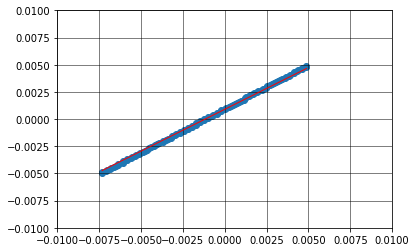

In [68]:
optim_R, optim_b, data_square = herbertNIN_debug(NIN_Vinc, NIN_Iinc, NIN_Vinc_err, [2.5, 2, 0.0015, .001])
#print("test R: " + str(optim_R) + "\nb: " + str(optim_b))   


#plt.plot(NIN_Vinc, NINcurr(NIN_Vinc, [optim_R, optim_b]))
#plt.scatter(NIN_Vinc, NIN_Iinc)

plt.scatter(NIN_Vinc, NIN_Iinc)
plt.plot(NIN_Vinc, NINcurr(NIN_Vinc, [optim_R, optim_b]), color='r', linewidth=1)
plt.grid(color='k', linestyle='-', linewidth=0.5)

plt.xlim(-.01, .01)
plt.ylim(-.01, .01)

In [59]:
data_square

[[40313.6584764962,
  41692.9789341518,
  43180.38373231865,
  44775.87287099677,
  46479.4463501861,
  48291.10416988672,
  50210.84633009855,
  52238.67283082164,
  54374.583672056026,
  56618.578853801584,
  58970.65837605845,
  61430.822238826506,
  63999.07044210586,
  66675.40298589642,
  69459.81987019823,
  72352.32109501131,
  75352.90666033559,
  78461.57656617115,
  81678.33081251805,
  85003.1693993761,
  88436.09232674539,
  91977.09959462594,
  95626.19120301778,
  99383.36715192083,
  103248.62744133516,
  107221.9720712607,
  111303.4010416976,
  115492.91435264552,
  119790.51200410484,
  124196.19399607548],
 [40313.6584764962,
  41692.9789341518,
  43180.38373231865,
  44775.87287099677,
  46479.4463501861,
  48291.10416988672,
  50210.84633009855,
  52238.67283082164,
  54374.583672056026,
  56618.578853801584,
  58970.65837605845,
  61430.822238826506,
  63999.07044210586,
  66675.40298589642,
  69459.81987019823,
  72352.32109501131,
  75352.90666033559,
  78461.5

In [9]:
#DEBUGGING SIN FIT
def herbertSIN_debug(v, current, current_err, firstGuess = []):

    #original parameter guesses
    r        = firstGuess[0]
    #r_sig    = firstGuess[1]
    delt     = firstGuess[1]
    delt_sig = firstGuess[2]
    t        = firstGuess[3]
    t_sig    = firstGuess[4]
    I        = 0
    
    #range over which to evaluate 
    #R range is small
    #R_range   = np.arange(10, 20, 1)
    #del_range = np.arange(0.002, 0.003, 0.0001)
    #T_range   = np.arange(3.5, 4.5, 0.1)
    
    #[0.079, 0.001, 
    #0.00259, 0.0005, 
    #4.2, 2.0]
    
    R_range = np.arange(r - r_sig, r + r_sig, (2 * r_sig)/2)
    del_range = np.arange(delt - delt_sig, delt + delt_sig, (2 * delt_sig)/2)
    T_range = np.arange(t - t_sig, t + t_sig, (2 * t_sig)/2)

    
    #final optimized values of fit parameters
    optim_R   = 0
    optim_del = 0
    optim_T   = 0
    
    #default maximum value
    scoreboard = 1000000000000000000000000
    
    for i in range(len(R_range))
        for j in range(len(del_range)):
            for k in range(len(T_range)):
                I = SINcurr(v, [r, del_range[j], T_range[k]])
                print(str(I))
                #calculate reduced chi squared

                for m in range(len(v)):
                    sum_lsq = 0
                    lsq = ((I[m]-current[m])**2)/(current_err[m]**2)
                    sum_lsq += lsq

                chi_sq = lsq / (len(v)-3)
                if(chi_sq < scoreboard):
                    print("surpassed scoreboard")
                    scoreboard = chi_sq
                    #optim_R    = R_range[i]
                    optim_del  = del_range[j]
                    optim_T    = T_range[k]

    print("R: " + str(r) + "\ndelta: " + str(optim_del) + "\nT: " + str(optim_T))   
    return optim_del, optim_T

(-0.01, 0.01)

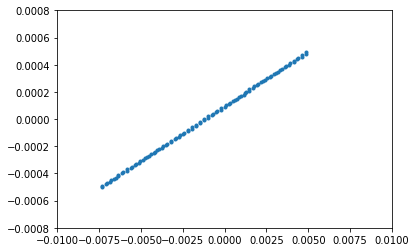

In [10]:
plt.scatter(NIN_Vinc, NIN_Iinc, marker='.')
#from NIN b offset, m=12.46 Ohms, b= -0.0012 V
#for SIN data, T is fixed at 4.2K
#delta = (4.2 K)(kB)(transition temp of lead) = (4.2 K)(kB)(7.175 K) = 0.00259 eV

#plt.plot(NIN_Vinc, NINcurr(SIN_Vinc, [12.46, 0.00259, 4.2]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

In [ ]:
optim_R, optim_del, optim_T = herbertSIN(SIN_Vinc, SIN_Iinc, SIN_Vinc_err, [79.9, 10, 0.00259, 0.002, .00036204, 0.00005])
#del sigma should be 0.005
plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [optim_R, optim_del, optim_T]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

/Users/ibhallaladd/opt/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars


bitch: 0.18972933540530887
surpassed scoreboard
bitch: 0.18972901549250037
surpassed scoreboard
bitch: 0.18972858481159524
surpassed scoreboard
bitch: 0.1897280161606928
surpassed scoreboard
bitch: 0.1897272785098532
surpassed scoreboard
bitch: 0.18972633697804844
surpassed scoreboard
bitch: 0.18972515287633412
surpassed scoreboard
bitch: 0.18972368381407118
surpassed scoreboard
bitch: 0.1897218838633122
surpassed scoreboard
bitch: 0.18971970377518896
surpassed scoreboard
bitch: 0.18971709124128514
surpassed scoreboard
bitch: 0.18972933316111418
bitch: 0.18972901223927802
bitch: 0.18972858019997607
bitch: 0.18972800975551254
bitch: 0.18972726977807933
bitch: 0.1897263252766352
bitch: 0.1897251374402139
bitch: 0.1897236637444828
bitch: 0.1897218581166474
bitch: 0.18971967115252408
bitch: 0.18971705037873798
surpassed scoreboard
bitch: 0.1897293297401704
bitch: 0.18972900728022035
bitch: 0.18972857317024305
bitch: 0.18972799999176027
bitch: 0.18972725646777835
bitch: 0.18972630743955712


bitch: 0.1897252065974159
bitch: 0.18972375366063998
bitch: 0.18972197346735464
bitch: 0.18971981730922496
bitch: 0.18971723345192762
bitch: 0.1897293332553036
bitch: 0.1897290123758166
bitch: 0.18972858039352702
bitch: 0.18972801002433973
bitch: 0.18972727014455423
bitch: 0.1897263257677466
bitch: 0.189725138088072
bitch: 0.18972366458680878
bitch: 0.1897218591972419
bitch: 0.18971967252170602
bitch: 0.18971705209375003
bitch: 0.189729321523915
bitch: 0.18972899536979843
bitch: 0.18972855628657434
bitch: 0.18972797654165807
bitch: 0.18972722449974982
bitch: 0.1897262645993382
bitch: 0.18972505739671885
bitch: 0.189723559674294
bitch: 0.1897217246081727
bitch: 0.18971950198878876
bitch: 0.18971683848738324
bitch: 0.18972930778126212
bitch: 0.18972897544821818
bitch: 0.18972852804665485
bitch: 0.1897279373186084
bitch: 0.18972717102946954
bitch: 0.18972619294404608
bitch: 0.18972496287141857
bitch: 0.18972343677529832
bitch: 0.1897215669448085
bitch: 0.18971930221929142
bitch: 0.1897165

bitch: 0.1897256675454101
bitch: 0.189724352971772
bitch: 0.18972274230560146
bitch: 0.18972079147660897
bitch: 0.18971845367649245
bitch: 0.18972940380869815
bitch: 0.18972911465120804
bitch: 0.18972872537444865
bitch: 0.18972821139157656
bitch: 0.18972754465569658
bitch: 0.18972669363901476
bitch: 0.18972562337184135
bitch: 0.1897242955385774
bitch: 0.18972266862626655
bitch: 0.18972069812014186
bitch: 0.1897183367398247
bitch: 0.18972939606000536
bitch: 0.18972910341857172
bitch: 0.18972870945157583
bitch: 0.18972818927594176
bitch: 0.18972751450685613
bitch: 0.18972665323667146
bitch: 0.18972557007438157
bitch: 0.18972422624276666
bitch: 0.18972257972873904
bitch: 0.18972058548125012
bitch: 0.18971819565034068
bitch: 0.18972938684766696
bitch: 0.1897290900642102
bitch: 0.18972869052104252
bitch: 0.18972816298290038
bitch: 0.18972747866322337
bitch: 0.18972660520276094
bitch: 0.1897255067096082
bitch: 0.18972414385773062
bitch: 0.18972247403944095
bitch: 0.18972045156611292
bitch: 0

bitch: 0.18972700396537998
bitch: 0.18972603274436983
bitch: 0.18972482779295857
bitch: 0.18972335143968108
bitch: 0.18972156328894138
bitch: 0.18971942043531684
bitch: 0.18972945954290432
bitch: 0.18972919544445999
bitch: 0.1897288399032824
bitch: 0.18972837046325042
bitch: 0.18972776150802612
bitch: 0.1897269842420057
bitch: 0.18972600672592768
bitch: 0.1897247939645237
bitch: 0.18972330804217366
bitch: 0.1897215083014777
bitch: 0.18971935155895123
bitch: 0.18972945470328062
bitch: 0.18972918842885908
bitch: 0.18972882995828583
bitch: 0.18972835665042007
bitch: 0.1897277426778689
bitch: 0.18972695900778055
bitch: 0.18972597343774852
bitch: 0.18972475068418562
bitch: 0.1897232525190983
bitch: 0.18972143795013352
bitch: 0.18971926343805268
bitch: 0.18972944872965447
bitch: 0.18972917976938888
bitch: 0.1897288176830149
bitch: 0.18972833960101942
bitch: 0.1897277194355004
bitch: 0.18972692786076786
bitch: 0.18972593234961113
bitch: 0.1897246972625664
bitch: 0.18972318398607377
bitch: 0.1

bitch


/Users/ibhallaladd/opt/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


surpassed scoreboard
bitch
surpassed scoreboard
bitch
surpassed scoreboard
bitch
bitch
bitch
surpassed scoreboard
R: 79.9
delta: 0.00259
T: 0.00041204


(-0.01, 0.01)

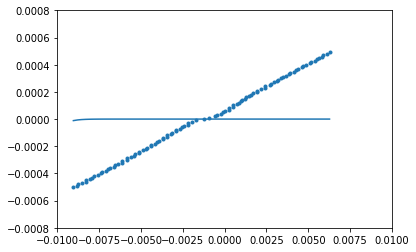

In [158]:
#this is the right order of inputs and outputs, we ARE trying to fit the squiggles 
optim_del, optim_T = herbertSIN_debug(SIN_Iinc, SIN_Vinc, SIN_Vinc_err, [79.9, 0.00259, 0.0005, .00036204, 0.00005])
#everything should be in meV (including temperature)
plt.scatter(SIN_Vinc, SIN_Iinc, marker='.')

plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [79.9, optim_del, optim_T]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

In [147]:
SINcurr(SIN_Vinc, [79.9, 2.59, .36204])

array([-6.52600015e-15, -6.35039922e-15, -6.32700628e-15, -6.17267522e-15,
       -5.99819280e-15, -5.99131697e-15, -5.81959392e-15, -5.73683348e-15,
       -5.64253539e-15, -5.46679281e-15, -5.34973810e-15, -5.29037274e-15,
       -5.11419772e-15, -5.04649886e-15, -4.93797279e-15, -4.76228680e-15,
       -4.74727602e-15, -4.58577834e-15, -4.41539378e-15, -4.40966168e-15,
       -4.23378923e-15, -4.21682625e-15, -4.05786703e-15, -3.92602231e-15,
       -3.88178526e-15, -3.70635050e-15, -3.69169349e-15, -3.53053616e-15,
       -3.39854885e-15, -3.35452608e-15, -3.17974697e-15, -3.17418836e-15,
       -3.00374786e-15, -2.93928566e-15, -2.82824780e-15, -2.65711455e-15,
       -2.65266190e-15, -2.47928818e-15, -2.47688102e-15, -2.30218127e-15,
       -2.29051863e-15, -2.12695796e-15, -2.08246249e-15, -1.95175820e-15,
       -1.85354773e-15, -1.77665476e-15, -1.60531886e-15, -1.59608623e-15,
       -1.42659111e-15, -1.24883579e-15, -9.01962230e-16, -6.82169090e-16,
       -4.45670489e-16, -

In [ ]:
plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [79.9, 0.00259, 0.00036204]))
#R = 79.9 (Ohms)
#del_Pb = 0.00259 eV
#T = 0.00036204 eV
#T = 0.36204 meV
plt.scatter(SIN_Vinc, SIN_Iinc, marker='.')
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

In [ ]:
plt.scatter(SIN_Vinc, SIN_Iinc, marker='.')
#from NIN b offset, m=12.46 Ohms, b= -0.0012 V
#for SIN data, T is fixed at 4.2K
#delta = (4.2 K)(kB)(transition temp of lead) = (4.2 K)(kB)(7.175 K) = 0.00259 eV

plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [10, .0025, 4.3999999]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

(-0.01, 0.01)

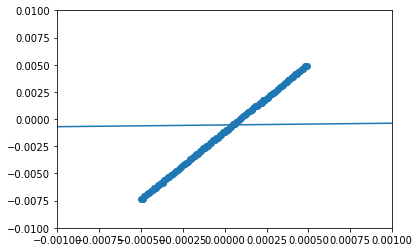

In [35]:
plt.plot(NIN_Vinc, NINcurr(NIN_Vinc, [0.07999999999999999, 0.0001]))
plt.scatter(NIN_Iinc, NIN_Vinc)

plt.xlim(-0.001, 0.001)
plt.ylim(-0.01, 0.01)

In [67]:
def red_chisq(o, c, var, m):
    #v = n - m
    v = len(o) - m
    chi = 0
    for i in range(len(o)):
        chi = chi + ( (o[i] - c[i])**2) / (var[i]**2)
        #print(o[i]-c[i])
        #print(str(beta[i])+ ": "+str((o[i]-c[i])**2/var[i]**2))
        
    return chi / v